### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Lectura de datos

In [3]:
current_db = pd.read_csv(r"Data/max_planck_weather_ts.csv")
current_db['Date Time'] = pd.to_datetime(current_db['Date Time'])

In [4]:
current_db.columns = ['fecha_completa', 'presion', 'temperatura', 'temperaturaK', 'temperaturaDew', 'humedad_relativa', 'VPmax', 'VPact', 'VPdef', 'humedad_especifica', 'concentracion_vapor_agua', 'rho', 'velocidad_viento', 'max_valocidad_viento', 'direccion_viento']

In [5]:
current_db

,fecha_completa,presion,temperatura,temperaturaK,temperaturaDew,humedad_relativa,VPmax,VPact,VPdef,humedad_especifica,concentracion_vapor_agua,rho,velocidad_viento,max_valocidad_viento,direccion_viento
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,2016-12-31 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [6]:
current_db = current_db[~current_db.duplicated()]

In [7]:
current_db['hora'] = current_db.fecha_completa.dt.hour
current_db['mes'] = current_db.fecha_completa.dt.month

In [8]:
current_db = current_db[(current_db.fecha_completa.dt.minute == 0)]
current_db = current_db.drop('temperaturaK', axis = 1)
current_db = current_db.reset_index(drop=True)

In [9]:
lags = sorted(([24, 48, 72, 96, 120, 144, 168])*len(current_db.columns))

In [10]:
for col, lag in list(zip(list(current_db.columns)*6, lags)):
    if col not in ['fecha_completa', 'hora', 'mes']:
        current_db[col+"_"+str(lag)] = current_db[col].shift(lag)

In [11]:
current_db = current_db.dropna()

In [12]:
current_db.drop(['temperatura', 'presion', 'temperaturaDew', 'humedad_relativa', 'VPmax', 'VPact', 'VPdef', 'humedad_especifica', 'concentracion_vapor_agua', 'rho', 'max_valocidad_viento', 'direccion_viento'],
                axis = 1)

,fecha_completa,velocidad_viento,hora,mes,presion_24,temperatura_24,temperaturaDew_24,humedad_relativa_24,VPmax_24,VPact_24,...,humedad_relativa_144,VPmax_144,VPact_144,VPdef_144,humedad_especifica_144,concentracion_vapor_agua_144,rho_144,velocidad_viento_144,max_valocidad_viento_144,direccion_viento_144
144,2009-07-01 01:00:00,0.68,1,7,997.71,-13.34,-15.46,83.9,2.18,1.83,...,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
145,2009-07-01 02:00:00,0.38,2,7,997.96,-13.64,-15.63,84.8,2.12,1.80,...,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
146,2009-07-01 03:00:00,1.83,3,7,998.22,-13.89,-15.80,85.3,2.08,1.77,...,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
147,2009-07-01 04:00:00,1.10,4,7,998.24,-14.29,-16.03,86.5,2.01,1.74,...,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
148,2009-07-01 05:00:00,0.70,5,7,998.14,-15.13,-16.75,87.3,1.88,1.64,...,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70032,2016-12-31 20:00:00,1.24,20,12,1008.99,-1.80,-2.78,93.0,5.35,4.98,...,80.5,11.81,9.51,2.30,5.96,9.54,1223.53,1.93,4.65,224.3
70033,2016-12-31 21:00:00,0.61,21,12,1009.24,-2.21,-3.75,89.1,5.19,4.62,...,82.1,11.60,9.53,2.08,5.97,9.56,1224.99,1.91,4.18,342.9
70034,2016-12-31 22:00:00,0.38,22,12,1008.93,-2.63,-4.99,83.7,5.03,4.21,...,83.0,11.38,9.44,1.93,5.91,9.47,1227.02,2.58,6.25,236.7
70035,2016-12-31 23:00:00,0.89,23,12,1008.82,-2.98,-4.85,86.9,4.90,4.26,...,82.1,11.35,9.32,2.03,5.83,9.34,1227.50,2.80,4.61,239.6


In [13]:
current_db = current_db.sort_values('fecha_completa')

In [14]:
current_db = current_db.reset_index(drop=True)

In [15]:
Index_col = "fecha_completa"
target_col = "velocidad_viento"

In [16]:
current_db.fecha_completa[current_db.fecha_completa.duplicated()]

Series([], Name: fecha_completa, dtype: datetime64[ns])

In [17]:
current_db.velocidad_viento.sort_values()

57066   -9999.00
57064   -9999.00
57065   -9999.00
631         0.00
6282        0.00
          ...   
57354      12.05
45586      12.21
10022      12.37
42131      12.49
27591      12.58
Name: velocidad_viento, Length: 69893, dtype: float64

In [18]:
current_db = current_db[current_db.velocidad_viento >= 0]

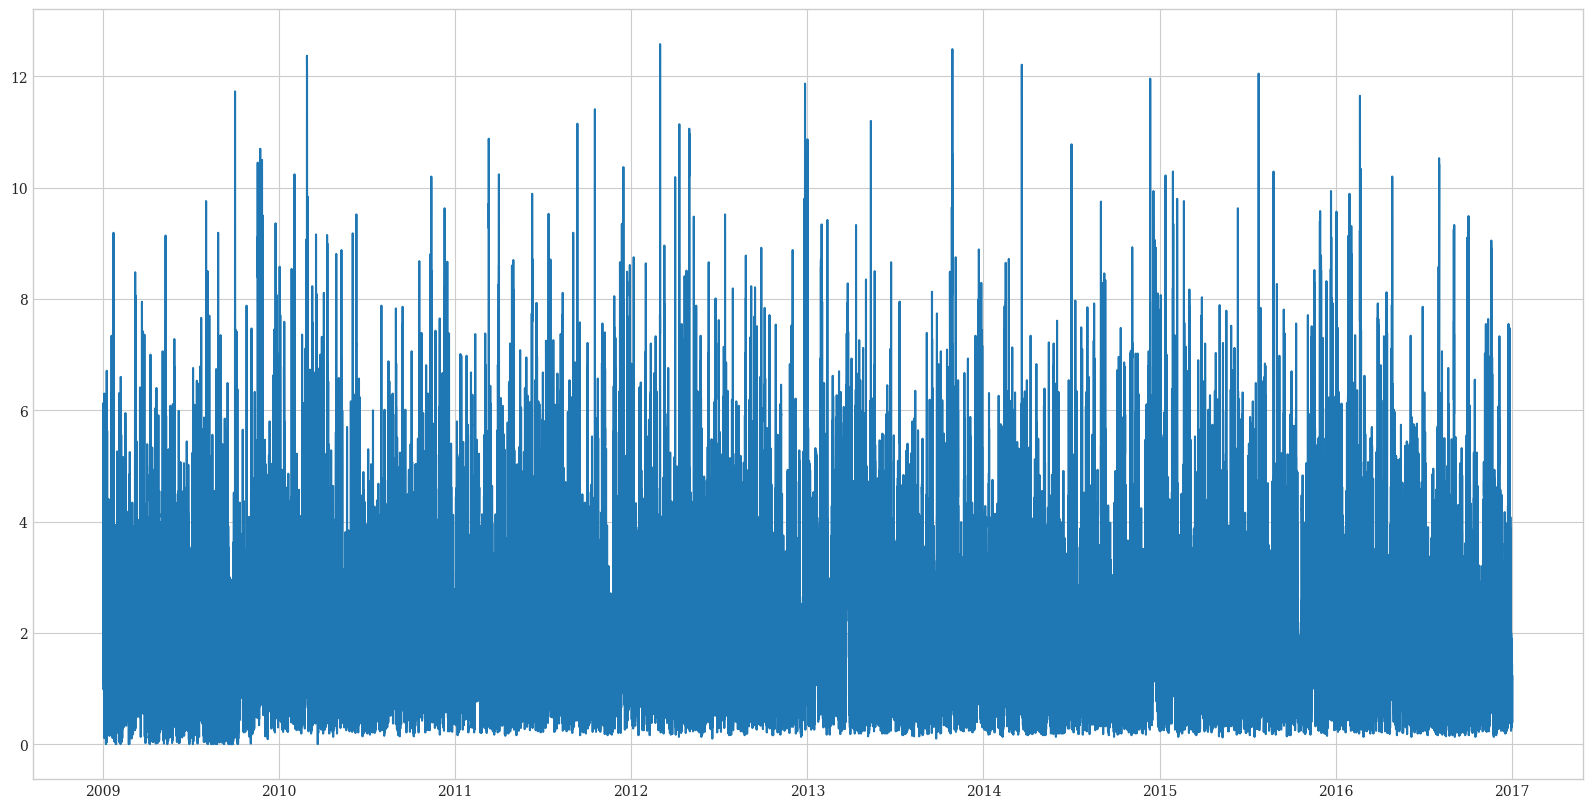

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db.fecha_completa, current_db.velocidad_viento)

In [20]:
# current_db['mes'] = pd.Categorical(current_db['mes'])
# current_db['hora'] = pd.Categorical(current_db['hora'])

In [21]:
current_db_train = current_db[current_db.fecha_completa.dt.year < 2015]
current_db_val = current_db[current_db.fecha_completa.dt.year == 2015]
current_db_test = current_db[current_db.fecha_completa.dt.year == 2016]

train_idx = current_db_train[Index_col].unique()
val_idx = current_db_val[Index_col].unique()
test_idx = current_db_test[Index_col].unique()

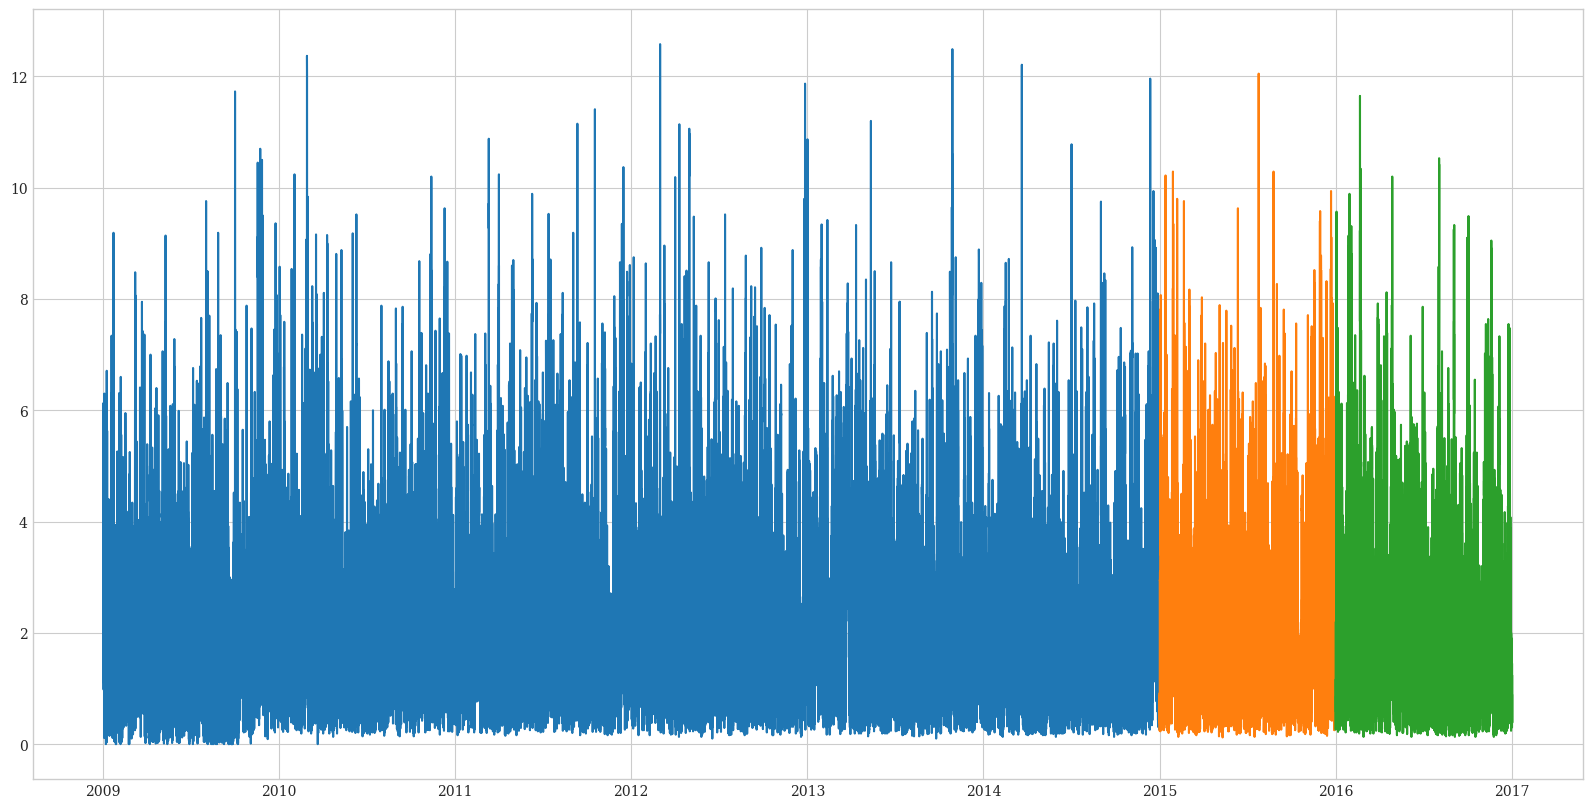

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db_train.fecha_completa, current_db_train.velocidad_viento)
ax.plot(current_db_val.fecha_completa, current_db_val.velocidad_viento)
ax.plot(current_db_test.fecha_completa, current_db_test.velocidad_viento)

In [23]:
selected_columns = list(current_db.columns)
selected_columns.remove('fecha_completa')
selected_columns.remove('temperatura')
selected_columns.remove('presion')
selected_columns.remove('temperaturaDew')
selected_columns.remove('humedad_relativa')
selected_columns.remove('VPmax')
selected_columns.remove('VPact')
selected_columns.remove('VPdef')
selected_columns.remove('humedad_especifica')
selected_columns.remove('concentracion_vapor_agua')
selected_columns.remove('rho')
selected_columns.remove('velocidad_viento')
selected_columns.remove('direccion_viento')
selected_columns.remove('max_valocidad_viento')

In [24]:
selected_columns

['hora',
 'mes',
 'presion_24',
 'temperatura_24',
 'temperaturaDew_24',
 'humedad_relativa_24',
 'VPmax_24',
 'VPact_24',
 'VPdef_24',
 'humedad_especifica_24',
 'concentracion_vapor_agua_24',
 'rho_24',
 'velocidad_viento_24',
 'max_valocidad_viento_24',
 'direccion_viento_24',
 'presion_48',
 'temperatura_48',
 'temperaturaDew_48',
 'humedad_relativa_48',
 'VPmax_48',
 'VPact_48',
 'VPdef_48',
 'humedad_especifica_48',
 'concentracion_vapor_agua_48',
 'rho_48',
 'velocidad_viento_48',
 'max_valocidad_viento_48',
 'direccion_viento_48',
 'presion_72',
 'temperatura_72',
 'temperaturaDew_72',
 'humedad_relativa_72',
 'VPmax_72',
 'VPact_72',
 'VPdef_72',
 'humedad_especifica_72',
 'concentracion_vapor_agua_72',
 'rho_72',
 'velocidad_viento_72',
 'max_valocidad_viento_72',
 'direccion_viento_72',
 'presion_96',
 'temperatura_96',
 'temperaturaDew_96',
 'humedad_relativa_96',
 'VPmax_96',
 'VPact_96',
 'VPdef_96',
 'humedad_especifica_96',
 'concentracion_vapor_agua_96',
 'rho_96',
 'v

In [25]:
X_train = current_db_train[selected_columns]
y_train = current_db_train[target_col]

X_val = current_db_val[selected_columns]
y_val = current_db_val[target_col]

X_test = current_db_test[selected_columns]
y_test = current_db_test[target_col]

In [26]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [27]:
current_db_train_val = current_db_train.append(current_db_val)

In [28]:
seeds = np.random.randint(1, 999999, 50)

## SHAPEffects 0.75-0.25

In [29]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_075_025 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.25, 0.75)
selected_features_shapeffects_075_025 = sorted(list(selected_features_shapeffects_075_025))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_72']
	79 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_96']
	78 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_120']
	77 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_144']
	76 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mes']
	75 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	Selecting featu


Iteration 54
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPdef_48']
	26 features left

Iteration 55
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['temperatura_120']
	25 features left

Iteration 56
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['rho_120']
	24 features left

Iteration 57
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['velocidad_viento_144']
	23 features left

Iteration 58
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_72']
	22 features left

Iteration 59
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['humedad_especifica_120']
	21 features left

Iteration 60
	Clasifying residuals
	Giving weights to features
	Select

In [30]:
feat_sel.best_mae

1.0891496688301963

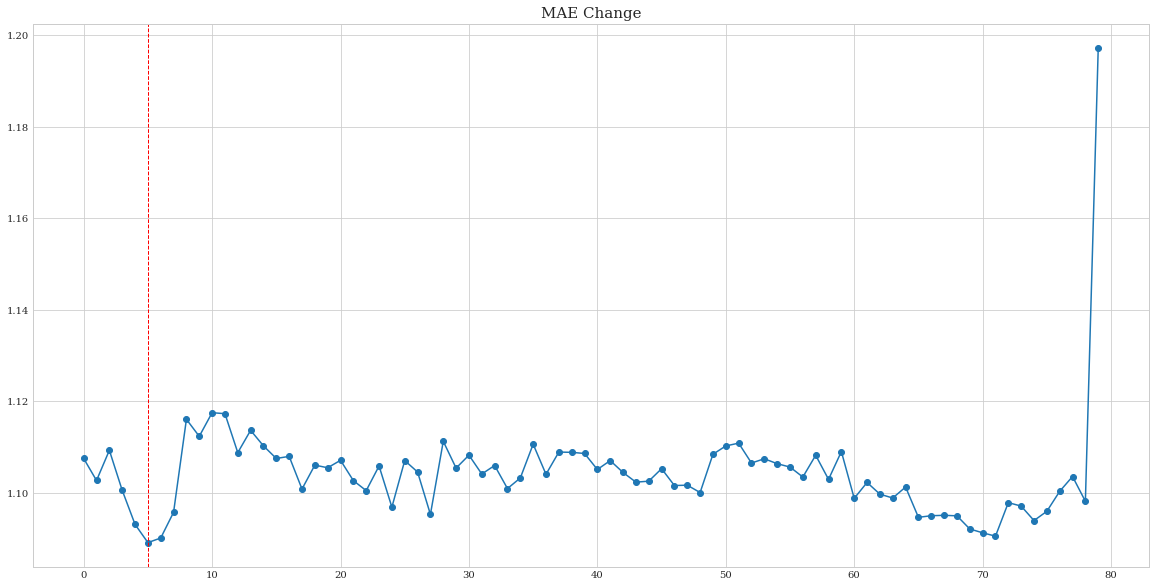

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [32]:
selected_features_shapeffects_075_025

['VPact_120',
 'VPact_144',
 'VPact_24',
 'VPact_48',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPdef_96',
 'VPmax_120',
 'VPmax_144',
 'VPmax_24',
 'VPmax_48',
 'VPmax_72',
 'VPmax_96',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_48',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_72',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_120',
 'humedad_especifica_144',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_especifica_72',
 'humedad_especifica_96',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_vient

In [33]:
dict_results_shapeffects_075_025 = {'rmse':[], 'mae':[], 'r2':[]}

In [34]:
X_test_shapeffects = X_test[selected_features_shapeffects_075_025]
X_train_shapeffects= X_train[selected_features_shapeffects_075_025]
X_val_shapeffects = X_val[selected_features_shapeffects_075_025]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_075_025["r2"].append(test_results["R2"])
    dict_results_shapeffects_075_025["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_075_025["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [35]:
results_shapeffects_075_025_df = pd.DataFrame(dict_results_shapeffects_075_025)
mean_shapeffects_075_025_test = results_shapeffects_075_025_df.mean()
std_shapeffects_075_025_test = results_shapeffects_075_025_df.std()
max_shapeffects_075_025_test = results_shapeffects_075_025_df.max()
min_shapeffects_075_025_test = results_shapeffects_075_025_df.min()

In [36]:
mean_shapeffects_075_025_test, std_shapeffects_075_025_test, max_shapeffects_075_025_test, min_shapeffects_075_025_test

(rmse    1.394002
 mae     1.038946
 r2      0.177321
 dtype: float64,
 rmse    0.002695
 mae     0.002195
 r2      0.003182
 dtype: float64,
 rmse    1.400444
 mae     1.045100
 r2      0.183675
 dtype: float64,
 rmse    1.388611
 mae     1.034301
 r2      0.169703
 dtype: float64)

## SHAPEffects 0.8-0.2

In [37]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_08_02 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.2, 0.8)
selected_features_shapeffects_08_02 = sorted(list(selected_features_shapeffects_08_02))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_72']
	79 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_96']
	78 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mes']
	77 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_24']
	76 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_120']
	75 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	Sel


Iteration 54
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['direccion_viento_24']
	26 features left

Iteration 55
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['humedad_relativa_48']
	25 features left

Iteration 56
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['humedad_relativa_120']
	24 features left

Iteration 57
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPact_144']
	23 features left

Iteration 58
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['humedad_relativa_144']
	22 features left

Iteration 59
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['rho_48']
	21 features left

Iteration 60
	Clasifying residuals
	Giving weights to features
	Selectin

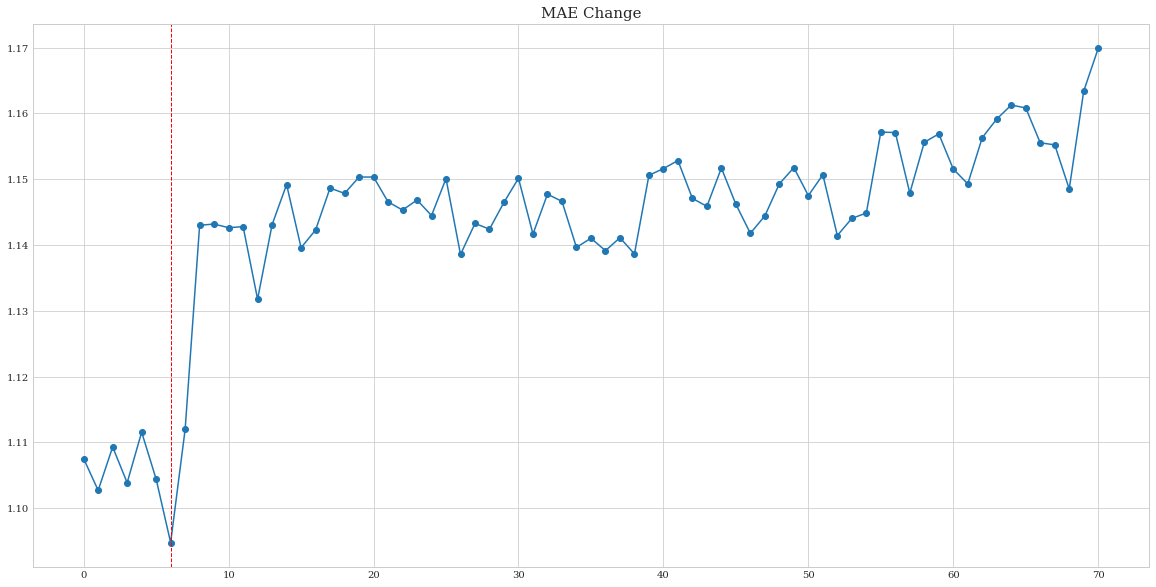

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [39]:
selected_features_shapeffects_08_02

['VPact_120',
 'VPact_144',
 'VPact_24',
 'VPact_48',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPdef_96',
 'VPmax_120',
 'VPmax_144',
 'VPmax_24',
 'VPmax_48',
 'VPmax_72',
 'VPmax_96',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_48',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_72',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_120',
 'humedad_especifica_144',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_especifica_72',
 'humedad_especifica_96',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_48',
 'max_valocidad_vient

In [42]:
dict_results_shapeffects_08_02 = {'rmse':[], 'mae':[], 'r2':[]}

In [43]:
X_test_shapeffects = X_test[selected_features_shapeffects_08_02]
X_train_shapeffects= X_train[selected_features_shapeffects_08_02]
X_val_shapeffects = X_val[selected_features_shapeffects_08_02]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_08_02["r2"].append(test_results["R2"])
    dict_results_shapeffects_08_02["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_08_02["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [44]:
results_shapeffects_08_02_df = pd.DataFrame(dict_results_shapeffects_08_02)
mean_shapeffects_08_02_test = results_shapeffects_08_02_df.mean()
std_shapeffects_08_02_test = results_shapeffects_08_02_df.std()
max_shapeffects_08_02_test = results_shapeffects_08_02_df.max()
min_shapeffects_08_02_test = results_shapeffects_08_02_df.min()

In [45]:
mean_shapeffects_08_02_test, std_shapeffects_08_02_test, max_shapeffects_08_02_test, min_shapeffects_08_02_test

(rmse    1.398647
 mae     1.042341
 r2      0.171825
 dtype: float64,
 rmse    0.004062
 mae     0.002846
 r2      0.004814
 dtype: float64,
 rmse    1.412900
 mae     1.054017
 r2      0.181939
 dtype: float64,
 rmse    1.390086
 mae     1.036749
 r2      0.154868
 dtype: float64)

## SHAPEffects 0.85-0.15

In [46]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_085_015 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.15, 0.85)
selected_features_shapeffects_085_015 = sorted(list(selected_features_shapeffects_085_015))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_72']
	79 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mes']
	78 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_96']
	77 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['hora']
	76 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_24']
	75 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	Selecting 

	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPact_120']
	27 features left

Iteration 54
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['humedad_especifica_72']
	26 features left

Iteration 55
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['temperatura_120']
	25 features left

Iteration 56
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['temperaturaDew_144']
	24 features left

Iteration 57
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['concentracion_vapor_agua_72']
	23 features left

Iteration 58
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPdef_120']
	22 features left

Iteration 59
	Clasifying residuals
	Giving weights to features
	Selecting featur

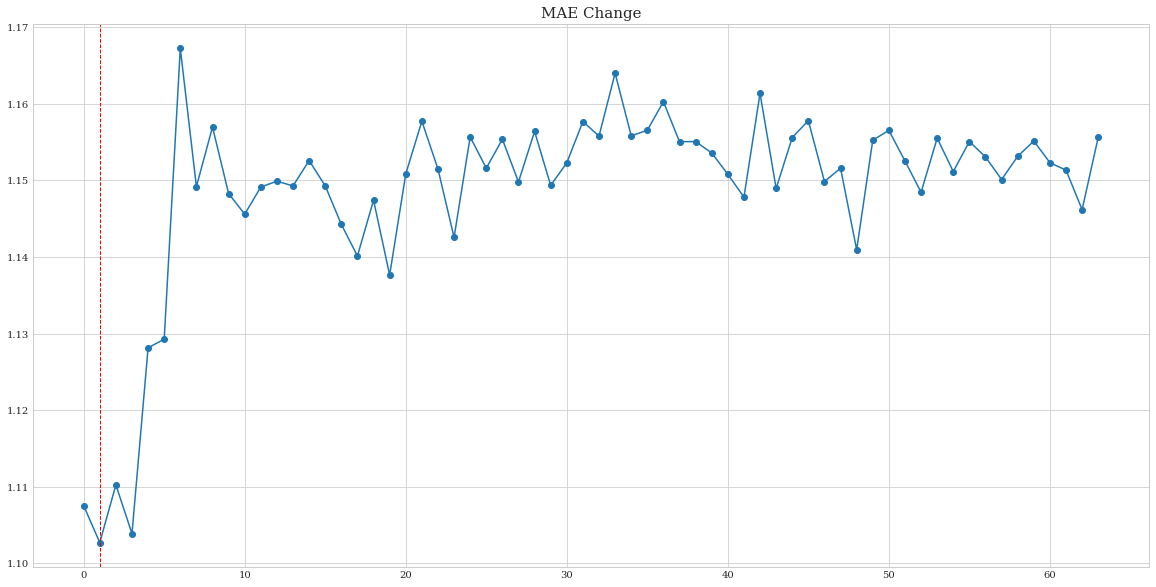

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [48]:
selected_features_shapeffects_085_015

['VPact_120',
 'VPact_144',
 'VPact_24',
 'VPact_48',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPdef_96',
 'VPmax_120',
 'VPmax_144',
 'VPmax_24',
 'VPmax_48',
 'VPmax_72',
 'VPmax_96',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_48',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_72',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_120',
 'humedad_especifica_144',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_especifica_72',
 'humedad_especifica_96',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_vient

In [49]:
dict_results_shapeffects_085_015 = {'rmse':[], 'mae':[], 'r2':[]}

In [50]:
X_test_shapeffects = X_test[selected_features_shapeffects_085_015]
X_train_shapeffects= X_train[selected_features_shapeffects_085_015]
X_val_shapeffects = X_val[selected_features_shapeffects_085_015]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_085_015["r2"].append(test_results["R2"])
    dict_results_shapeffects_085_015["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_085_015["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [51]:
results_shapeffects_085_015_df = pd.DataFrame(dict_results_shapeffects_085_015)
mean_shapeffects_085_015_test = results_shapeffects_085_015_df.mean()
std_shapeffects_085_015_test = results_shapeffects_085_015_df.std()
max_shapeffects_085_015_test = results_shapeffects_085_015_df.max()
min_shapeffects_085_015_test = results_shapeffects_085_015_df.min()

In [52]:
mean_shapeffects_085_015_test, std_shapeffects_085_015_test, max_shapeffects_085_015_test, min_shapeffects_085_015_test

(rmse    1.399090
 mae     1.041792
 r2      0.171303
 dtype: float64,
 rmse    0.003499
 mae     0.002535
 r2      0.004151
 dtype: float64,
 rmse    1.410870
 mae     1.051223
 r2      0.178527
 dtype: float64,
 rmse    1.392983
 mae     1.037934
 r2      0.157295
 dtype: float64)

## SHAPEffects 0.9-0.1

In [53]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_09_01 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.1, 0.9)
selected_features_shapeffects_09_01 = sorted(list(selected_features_shapeffects_09_01))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['hora']
	79 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_24']
	78 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_72']
	77 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_96']
	76 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_120']
	75 features left

Iteration 6
	Clasifying residuals
	Giving weights to

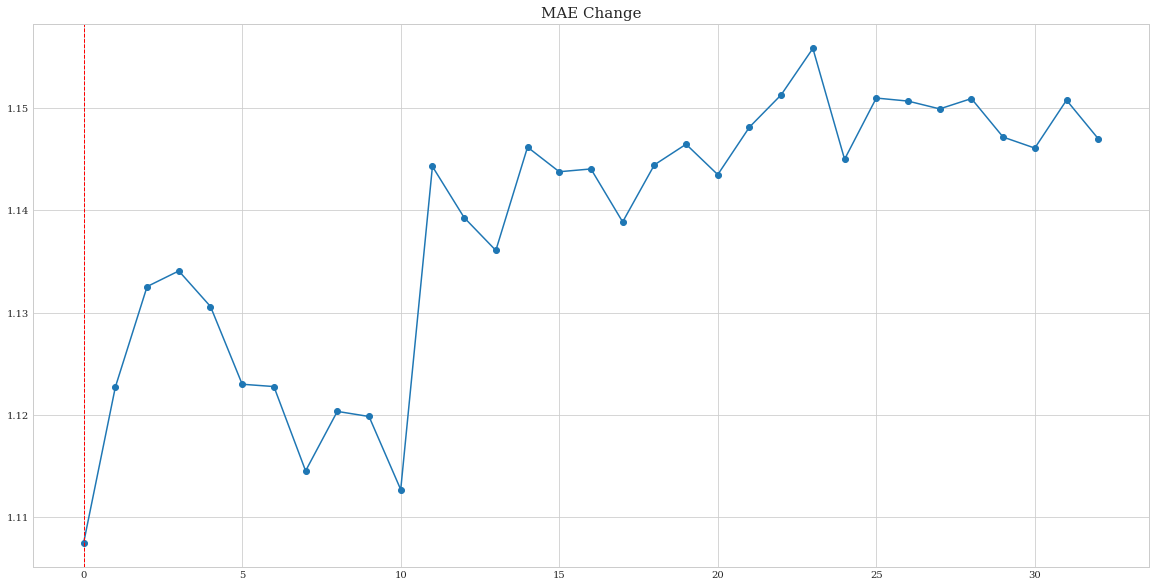

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [55]:
selected_features_shapeffects_09_01

['VPact_120',
 'VPact_144',
 'VPact_24',
 'VPact_48',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPdef_96',
 'VPmax_120',
 'VPmax_144',
 'VPmax_24',
 'VPmax_48',
 'VPmax_72',
 'VPmax_96',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_48',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_72',
 'direccion_viento_96',
 'humedad_especifica_120',
 'humedad_especifica_144',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_especifica_72',
 'humedad_especifica_96',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_144',
 'max_valocidad_viento_72',
 'max_valocidad_viento_96',
 'mes',
 'presion_144',
 'presi

In [56]:
dict_results_shapeffects_09_01 = {'rmse':[], 'mae':[], 'r2':[]}

In [57]:
X_test_shapeffects = X_test[selected_features_shapeffects_09_01]
X_train_shapeffects= X_train[selected_features_shapeffects_09_01]
X_val_shapeffects = X_val[selected_features_shapeffects_09_01]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_09_01["r2"].append(test_results["R2"])
    dict_results_shapeffects_09_01["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_09_01["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [58]:
results_shapeffects_09_01_df = pd.DataFrame(dict_results_shapeffects_09_01)
mean_shapeffects_09_01_test = results_shapeffects_09_01_df.mean()
std_shapeffects_09_01_test = results_shapeffects_09_01_df.std()
max_shapeffects_09_01_test = results_shapeffects_09_01_df.max()
min_shapeffects_09_01_test = results_shapeffects_09_01_df.min()

In [59]:
mean_shapeffects_09_01_test, std_shapeffects_09_01_test, max_shapeffects_09_01_test, min_shapeffects_09_01_test

(rmse    1.416082
 mae     1.056653
 r2      0.151050
 dtype: float64,
 rmse    0.003980
 mae     0.002682
 r2      0.004774
 dtype: float64,
 rmse    1.427596
 mae     1.061737
 r2      0.163013
 dtype: float64,
 rmse    1.406074
 mae     1.049372
 r2      0.137194
 dtype: float64)

## SHAPEffects 0.95-0.05

In [60]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_095_005 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.05, 0.95)
selected_features_shapeffects_095_005 = sorted(list(selected_features_shapeffects_095_005))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_96']
	79 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['presion_72']
	78 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_valocidad_viento_120']
	77 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPact_24']
	76 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['VPmax_48']
	75 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	

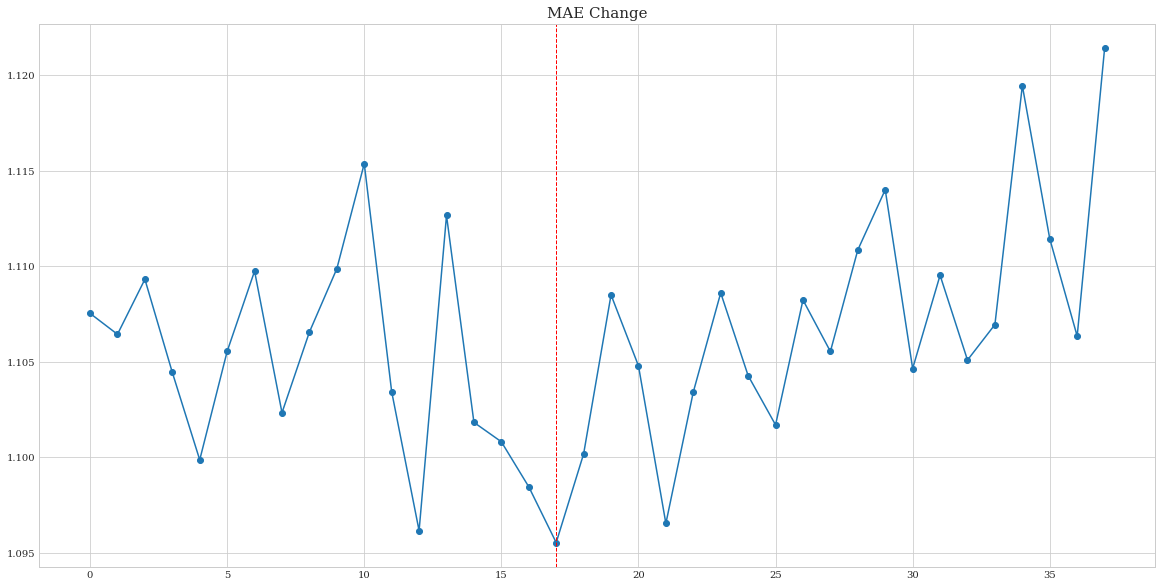

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [62]:
selected_features_shapeffects_095_005

['VPact_120',
 'VPact_72',
 'VPact_96',
 'VPdef_120',
 'VPdef_144',
 'VPdef_24',
 'VPdef_48',
 'VPdef_72',
 'VPdef_96',
 'VPmax_120',
 'VPmax_144',
 'VPmax_24',
 'VPmax_96',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_144',
 'concentracion_vapor_agua_48',
 'concentracion_vapor_agua_72',
 'concentracion_vapor_agua_96',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'direccion_viento_72',
 'direccion_viento_96',
 'hora',
 'humedad_especifica_120',
 'humedad_especifica_144',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_especifica_72',
 'humedad_especifica_96',
 'humedad_relativa_120',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'humedad_relativa_48',
 'humedad_relativa_72',
 'humedad_relativa_96',
 'max_valocidad_viento_144',
 'max_valocidad_viento_72',
 'max_valocidad_viento_96',
 'presion_120',
 'presion_144',
 'presion_24',
 'presion_48',
 'rho_24',
 'rho_48',
 'temperaturaDew_120',
 'temperatura

In [63]:
dict_results_shapeffects_095_005 = {'rmse':[], 'mae':[], 'r2':[]}

In [64]:
X_test_shapeffects = X_test[selected_features_shapeffects_095_005]
X_train_shapeffects= X_train[selected_features_shapeffects_095_005]
X_val_shapeffects = X_val[selected_features_shapeffects_095_005]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_095_005["r2"].append(test_results["R2"])
    dict_results_shapeffects_095_005["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_095_005["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [65]:
results_shapeffects_095_005_df = pd.DataFrame(dict_results_shapeffects_095_005)
mean_shapeffects_095_005_test = results_shapeffects_095_005_df.mean()
std_shapeffects_095_005_test = results_shapeffects_095_005_df.std()
max_shapeffects_095_005_test = results_shapeffects_095_005_df.max()
min_shapeffects_095_005_test = results_shapeffects_095_005_df.min()

In [66]:
mean_shapeffects_095_005_test, std_shapeffects_095_005_test, max_shapeffects_095_005_test, min_shapeffects_095_005_test

(rmse    1.398058
 mae     1.042759
 r2      0.172527
 dtype: float64,
 rmse    0.002563
 mae     0.002877
 r2      0.003035
 dtype: float64,
 rmse    1.406546
 mae     1.050689
 r2      0.179092
 dtype: float64,
 rmse    1.392503
 mae     1.037323
 r2      0.162451
 dtype: float64)

## PowerSHAP

In [67]:
selector = PowerShap(
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123),
    power_iterations=10,automatic=True, limit_automatic=10,verbose=True,target_col=target_col,index_col=Index_col,
)
selector.fit(current_db_train_val[list(selected_columns)], current_db_train_val[target_col])

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.



Automatic mode: Powershap requires 12 iterations; Adding 2  powershap iterations.



Done!


PowerShap(model=<catboost.core.CatBoostRegressor object at 0x0000029D9B049430>,
          verbose=True)

In [68]:
t = selector._processed_shaps_df
selected_features_powershap = t[(t.p_value<0.01)].index.values
selected_features_powershap

array(['hora', 'max_valocidad_viento_24', 'presion_24', 'presion_72',
       'mes', 'presion_120', 'max_valocidad_viento_48',
       'humedad_relativa_24', 'velocidad_viento_24', 'presion_96',
       'presion_48', 'presion_144', 'direccion_viento_48', 'VPact_48',
       'humedad_relativa_144', 'rho_72', 'direccion_viento_24', 'rho_144',
       'concentracion_vapor_agua_48', 'max_valocidad_viento_120',
       'concentracion_vapor_agua_24', 'humedad_especifica_24',
       'humedad_especifica_72', 'temperaturaDew_48', 'VPact_24',
       'VPdef_24', 'rho_48', 'direccion_viento_144', 'temperaturaDew_24',
       'direccion_viento_120', 'temperaturaDew_72',
       'max_valocidad_viento_144', 'concentracion_vapor_agua_72',
       'rho_96', 'humedad_especifica_48', 'VPact_72', 'rho_24',
       'velocidad_viento_48', 'rho_120', 'humedad_relativa_72',
       'humedad_relativa_120', 'VPdef_48', 'humedad_especifica_144',
       'concentracion_vapor_agua_144', 'concentracion_vapor_agua_96',
       '

In [69]:
selected_features_powershap = sorted(selected_features_powershap)

In [29]:
selected_features_powershap = sorted(['hora', 'max_valocidad_viento_24', 'presion_24', 'presion_72',
       'mes', 'presion_120', 'max_valocidad_viento_48',
       'humedad_relativa_24', 'velocidad_viento_24', 'presion_96',
       'presion_48', 'presion_144', 'direccion_viento_48', 'VPact_48',
       'humedad_relativa_144', 'rho_72', 'direccion_viento_24', 'rho_144',
       'concentracion_vapor_agua_48', 'max_valocidad_viento_120',
       'concentracion_vapor_agua_24', 'humedad_especifica_24',
       'humedad_especifica_72', 'temperaturaDew_48', 'VPact_24',
       'VPdef_24', 'rho_48', 'direccion_viento_144', 'temperaturaDew_24',
       'direccion_viento_120', 'temperaturaDew_72',
       'max_valocidad_viento_144', 'concentracion_vapor_agua_72',
       'rho_96', 'humedad_especifica_48', 'VPact_72', 'rho_24',
       'velocidad_viento_48', 'rho_120', 'humedad_relativa_72',
       'humedad_relativa_120', 'VPdef_48', 'humedad_especifica_144',
       'concentracion_vapor_agua_144', 'concentracion_vapor_agua_96',
       'temperaturaDew_144', 'VPmax_48', 'temperatura_120',
       'temperatura_48', 'humedad_relativa_48', 'VPdef_96', 'VPact_144',
       'temperaturaDew_96', 'temperaturaDew_120', 'humedad_especifica_96',
       'temperatura_24', 'temperatura_72', 'VPmax_144', 'VPact_96',
       'velocidad_viento_144', 'humedad_relativa_96', 'VPmax_120',
       'velocidad_viento_120', 'VPmax_72', 'direccion_viento_72',
       'humedad_especifica_120', 'concentracion_vapor_agua_120',
       'VPact_120', 'VPdef_72', 'velocidad_viento_72',
       'max_valocidad_viento_96', 'VPmax_24', 'VPdef_120',
       'temperatura_96', 'VPdef_144', 'velocidad_viento_96',
       'temperatura_144', 'direccion_viento_96', 'VPmax_96'])

In [32]:
dict_results_powershap = {'rmse':[], 'mae':[], 'r2':[]}

In [33]:
X_test_powershap = X_test[selected_features_powershap]
X_train_powershap = X_train[selected_features_powershap]
X_val_powershap = X_val[selected_features_powershap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_powershap, y_train,
        eval_set=(X_val_powershap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_powershap), print_bool=False)
    
    dict_results_powershap["r2"].append(test_results["R2"])
    dict_results_powershap["rmse"].append(test_results["RMSE"])
    dict_results_powershap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [34]:
results_powershap_df = pd.DataFrame(dict_results_powershap)
mean_powershap_test = results_powershap_df.mean()
std_powershap_test = results_powershap_df.std()
max_powershap_test = results_powershap_df.max()
min_powershap_test = results_powershap_df.min()

In [35]:
mean_powershap_test, std_powershap_test, max_powershap_test, min_powershap_test

(rmse    1.401855
 mae     1.044146
 r2      0.168024
 dtype: float64,
 rmse    0.003509
 mae     0.003435
 r2      0.004167
 dtype: float64,
 rmse    1.410189
 mae     1.052529
 r2      0.175983
 dtype: float64,
 rmse    1.395137
 mae     1.036662
 r2      0.158108
 dtype: float64)

## BorutaSHAP

In [76]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)


33 attributes confirmed important: ['concentracion_vapor_agua_120', 'humedad_relativa_24', 'rho_144', 'humedad_relativa_144', 'direccion_viento_24', 'concentracion_vapor_agua_24', 'presion_96', 'presion_120', 'mes', 'rho_24', 'presion_24', 'VPact_24', 'hora', 'velocidad_viento_24', 'humedad_especifica_48', 'concentracion_vapor_agua_72', 'rho_96', 'temperaturaDew_48', 'presion_144', 'velocidad_viento_48', 'max_valocidad_viento_144', 'presion_48', 'direccion_viento_48', 'temperaturaDew_24', 'direccion_viento_144', 'presion_72', 'direccion_viento_120', 'humedad_especifica_24', 'max_valocidad_viento_48', 'VPdef_24', 'max_valocidad_viento_24', 'rho_72', 'max_valocidad_viento_120']
1 attributes confirmed unimportant: ['max_valocidad_viento_72']
46 tentative attributes remains: ['temperaturaDew_144', 'temperatura_144', 'VPmax_144', 'humedad_especifica_120', 'VPdef_96', 'temperaturaDew_120', 'velocidad_viento_144', 'VPmax_48', 'rho_48', 'temperatura_72', 'concentracion_vapor_agua_144', 'tempe

In [77]:
subset = Feature_Selector.Subset()
selected_features_borutashap = sorted(subset.columns.values)
selected_features_borutashap

['VPact_24',
 'VPdef_24',
 'concentracion_vapor_agua_120',
 'concentracion_vapor_agua_24',
 'concentracion_vapor_agua_72',
 'direccion_viento_120',
 'direccion_viento_144',
 'direccion_viento_24',
 'direccion_viento_48',
 'hora',
 'humedad_especifica_24',
 'humedad_especifica_48',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'max_valocidad_viento_120',
 'max_valocidad_viento_144',
 'max_valocidad_viento_24',
 'max_valocidad_viento_48',
 'mes',
 'presion_120',
 'presion_144',
 'presion_24',
 'presion_48',
 'presion_72',
 'presion_96',
 'rho_144',
 'rho_24',
 'rho_72',
 'rho_96',
 'temperaturaDew_24',
 'temperaturaDew_48',
 'velocidad_viento_24',
 'velocidad_viento_48']

In [36]:
selected_features_borutashap = sorted(['concentracion_vapor_agua_120', 'humedad_relativa_24', 'rho_144', 'humedad_relativa_144', 'direccion_viento_24', 'concentracion_vapor_agua_24', 'presion_96', 'presion_120', 'mes', 'rho_24', 'presion_24', 'VPact_24', 'hora', 'velocidad_viento_24', 'humedad_especifica_48', 'concentracion_vapor_agua_72', 'rho_96', 'temperaturaDew_48', 'presion_144', 'velocidad_viento_48', 'max_valocidad_viento_144', 'presion_48', 'direccion_viento_48', 'temperaturaDew_24', 'direccion_viento_144', 'presion_72', 'direccion_viento_120', 'humedad_especifica_24', 'max_valocidad_viento_48', 'VPdef_24', 'max_valocidad_viento_24', 'rho_72', 'max_valocidad_viento_120'])

In [37]:
dict_results_borutashap = {'rmse':[], 'mae':[], 'r2':[]}

In [38]:
X_test_borutashap = X_test[selected_features_borutashap]
X_train_borutashap = X_train[selected_features_borutashap]
X_val_borutashap = X_val[selected_features_borutashap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_borutashap, y_train,
        eval_set=(X_val_borutashap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_borutashap), print_bool=False)
    
    dict_results_borutashap["r2"].append(test_results["R2"])
    dict_results_borutashap["rmse"].append(test_results["RMSE"])
    dict_results_borutashap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [39]:
results_borutashap_df = pd.DataFrame(dict_results_borutashap)
mean_borutashap_test = results_borutashap_df.mean()
std_borutashap_test = results_borutashap_df.std()
max_borutashap_test = results_borutashap_df.max()
min_borutashap_test = results_borutashap_df.min()

In [40]:
mean_borutashap_test, std_borutashap_test, max_borutashap_test, min_borutashap_test

(rmse    1.401890
 mae     1.043999
 r2      0.167985
 dtype: float64,
 rmse    0.002535
 mae     0.002615
 r2      0.003010
 dtype: float64,
 rmse    1.407676
 mae     1.051450
 r2      0.173105
 dtype: float64,
 rmse    1.397572
 mae     1.037718
 r2      0.161105
 dtype: float64)

## Shapicant

In [82]:
# LightGBM in RandomForest-like mode (with rows subsampling), without columns subsampling
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)


# This is the class (not its instance) of SHAP's TreeExplainer
explainer_type = shap.TreeExplainer

# Use PandasSelector with 100 iterations
selector = shapicant.PandasSelector(model, explainer_type, random_state=42)

# Run the feature selection
# If we provide a validation set, SHAP values are computed on it, otherwise they are computed on the training set
# We can also provide additional parameters to the underlying estimator's fit method through estimator_params
selector.fit(X_train, y_train, X_validation=X_val)#, estimator_params={"categorical_feature": None})

# Just get the features list
selected_features = selector.get_features()

# We can also get the p-values as pandas Series
p_values = selector.p_values_

selected_features_shapicant = sorted(np.array(selected_features))

Computing null SHAP values: 100%|████████████████████████████████████████████████████| 100/100 [15:04<00:00,  9.04s/it]


In [83]:
selected_features_shapicant

['direccion_viento_24',
 'direccion_viento_48',
 'hora',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'max_valocidad_viento_24',
 'mes',
 'presion_120',
 'presion_144',
 'presion_24',
 'presion_72',
 'presion_96',
 'temperaturaDew_24']

In [41]:
selected_features_shapicant = sorted(['direccion_viento_24',
 'direccion_viento_48',
 'hora',
 'humedad_relativa_144',
 'humedad_relativa_24',
 'max_valocidad_viento_24',
 'mes',
 'presion_120',
 'presion_144',
 'presion_24',
 'presion_72',
 'presion_96',
 'temperaturaDew_24'])

In [44]:
dict_results_shapicant = {'rmse':[], 'mae':[], 'r2':[]}

In [45]:
X_test_shapicant = X_test[selected_features_shapicant]
X_train_shapicant= X_train[selected_features_shapicant]
X_val_shapicant = X_val[selected_features_shapicant]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapicant, y_train,
        eval_set=(X_val_shapicant, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapicant), print_bool=False)
    
    dict_results_shapicant["r2"].append(test_results["R2"])
    dict_results_shapicant["rmse"].append(test_results["RMSE"])
    dict_results_shapicant["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [46]:
results_shapicant_df = pd.DataFrame(dict_results_shapicant)
mean_shapicant_test = results_shapicant_df.mean()
std_shapicant_test = results_shapicant_df.std()
max_shapicant_test = results_shapicant_df.max()
min_shapicant_test = results_shapicant_df.min()

In [47]:
mean_shapicant_test, std_shapicant_test, max_shapicant_test, min_shapicant_test

(rmse    1.407807
 mae     1.048562
 r2      0.160946
 dtype: float64,
 rmse    0.002358
 mae     0.003185
 r2      0.002809
 dtype: float64,
 rmse    1.411837
 mae     1.053893
 r2      0.167193
 dtype: float64,
 rmse    1.402559
 mae     1.040509
 r2      0.156139
 dtype: float64)

# Results

In [88]:
nombres = ['PowerSHAP', 'BorutaSHAP', 'Shapicant', 'SHAPEffects_075_025', 'SHAPEffects_08_02', 'SHAPEffects_085_015', 'SHAPEffects_09_01', 'SHAPEffects_095_005']

## MAE

In [89]:
resultados_mae_mean = [mean_powershap_test['mae'], mean_borutashap_test['mae'], mean_shapicant_test['mae'], mean_shapeffects_075_025_test['mae'], mean_shapeffects_08_02_test['mae'], mean_shapeffects_085_015_test['mae'], mean_shapeffects_09_01_test['mae'], mean_shapeffects_095_005_test['mae']]
resultados_mae_std = [std_powershap_test['mae'], std_borutashap_test['mae'], std_shapicant_test['mae'], std_shapeffects_075_025_test['mae'], std_shapeffects_08_02_test['mae'], std_shapeffects_085_015_test['mae'], std_shapeffects_09_01_test['mae'], std_shapeffects_095_005_test['mae']]
resultados_mae_max = [max_powershap_test['mae'], max_borutashap_test['mae'], max_shapicant_test['mae'], max_shapeffects_075_025_test['mae'], max_shapeffects_08_02_test['mae'], max_shapeffects_085_015_test['mae'], max_shapeffects_09_01_test['mae'], max_shapeffects_095_005_test['mae']]
resultados_mae_min = [min_powershap_test['mae'], min_borutashap_test['mae'], min_shapicant_test['mae'], min_shapeffects_075_025_test['mae'], min_shapeffects_08_02_test['mae'], min_shapeffects_085_015_test['mae'], min_shapeffects_09_01_test['mae'], min_shapeffects_095_005_test['mae']]

(1.02, 1.07)

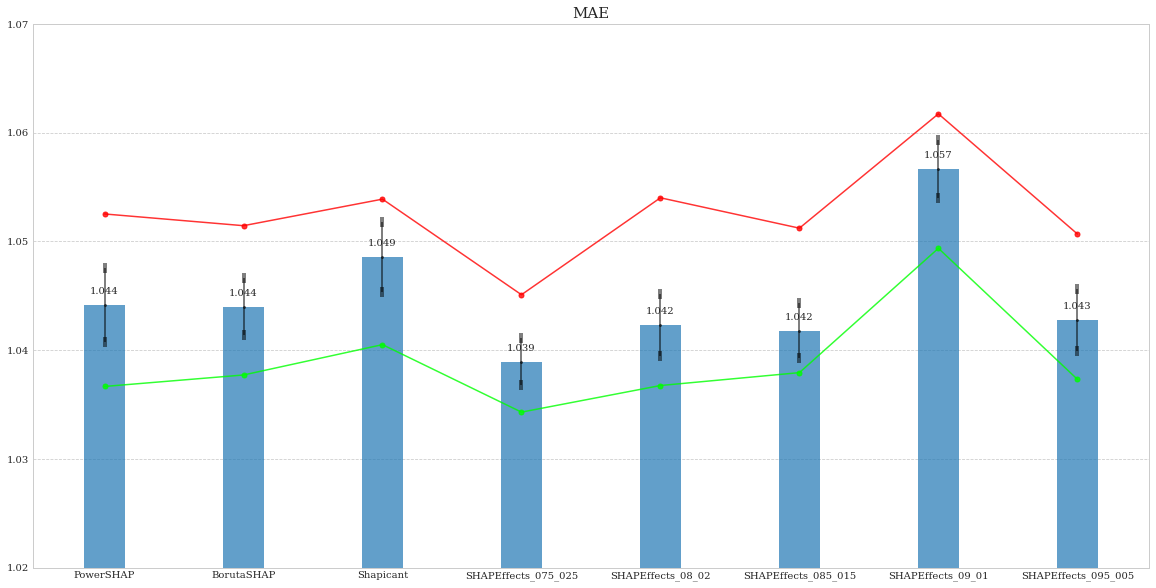

In [98]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([1.02, 1.07])


## RMSE

In [91]:
resultados_rmse_mean = [mean_powershap_test['rmse'], mean_borutashap_test['rmse'], mean_shapicant_test['rmse'], mean_shapeffects_075_025_test['rmse'], mean_shapeffects_08_02_test['rmse'], mean_shapeffects_085_015_test['rmse'], mean_shapeffects_09_01_test['rmse'], mean_shapeffects_095_005_test['rmse']]
resultados_rmse_std = [std_powershap_test['rmse'], std_borutashap_test['rmse'], std_shapicant_test['rmse'], std_shapeffects_075_025_test['rmse'], std_shapeffects_08_02_test['rmse'], std_shapeffects_085_015_test['rmse'], std_shapeffects_09_01_test['rmse'], std_shapeffects_095_005_test['rmse']]
resultados_rmse_max = [max_powershap_test['rmse'], max_borutashap_test['rmse'], max_shapicant_test['rmse'], max_shapeffects_075_025_test['rmse'], max_shapeffects_08_02_test['rmse'], max_shapeffects_085_015_test['rmse'], max_shapeffects_09_01_test['rmse'], max_shapeffects_095_005_test['rmse']]
resultados_rmse_min = [min_powershap_test['rmse'], min_borutashap_test['rmse'], min_shapicant_test['rmse'], min_shapeffects_075_025_test['rmse'], min_shapeffects_08_02_test['rmse'], min_shapeffects_085_015_test['rmse'], min_shapeffects_09_01_test['rmse'], min_shapeffects_095_005_test['rmse']]

(1.38, 1.43)

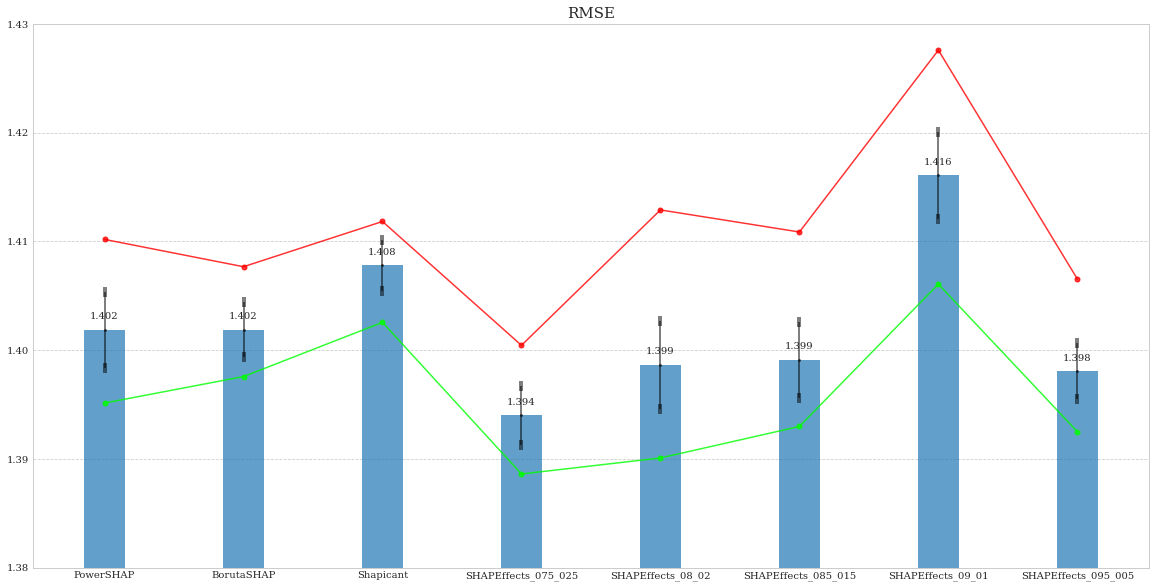

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([1.38, 1.43])

## R2

In [93]:
resultados_r2_mean = [mean_powershap_test['r2'], mean_borutashap_test['r2'], mean_shapicant_test['r2'], mean_shapeffects_075_025_test['r2'], mean_shapeffects_08_02_test['r2'], mean_shapeffects_085_015_test['r2'], mean_shapeffects_09_01_test['r2'], mean_shapeffects_095_005_test['r2']]
resultados_r2_std = [std_powershap_test['r2'], std_borutashap_test['r2'], std_shapicant_test['r2'], std_shapeffects_075_025_test['r2'], std_shapeffects_08_02_test['r2'], std_shapeffects_085_015_test['r2'], std_shapeffects_09_01_test['r2'], std_shapeffects_095_005_test['r2']]
resultados_r2_max = [max_powershap_test['r2'], max_borutashap_test['r2'], max_shapicant_test['r2'], max_shapeffects_075_025_test['r2'], max_shapeffects_08_02_test['r2'], max_shapeffects_085_015_test['r2'], max_shapeffects_09_01_test['r2'], max_shapeffects_095_005_test['r2']]
resultados_r2_min = [min_powershap_test['r2'], min_borutashap_test['r2'], min_shapicant_test['r2'], min_shapeffects_075_025_test['r2'], min_shapeffects_08_02_test['r2'], min_shapeffects_085_015_test['r2'], min_shapeffects_09_01_test['r2'], min_shapeffects_095_005_test['r2']]

In [94]:
resultados_r2_max, resultados_r2_min

([0.17598330916949056,
  0.17310454501795092,
  0.1671925703353172,
  0.18367483568750853,
  0.1819391489615405,
  0.17852666174004295,
  0.16301320939908648,
  0.17909192617102432],
 [0.1581078537090953,
  0.1611053219962999,
  0.15613858068927444,
  0.16970329686174623,
  0.15486779669514217,
  0.15729455926939684,
  0.1371944566319072,
  0.16245119084414017])

(0.13, 0.19)

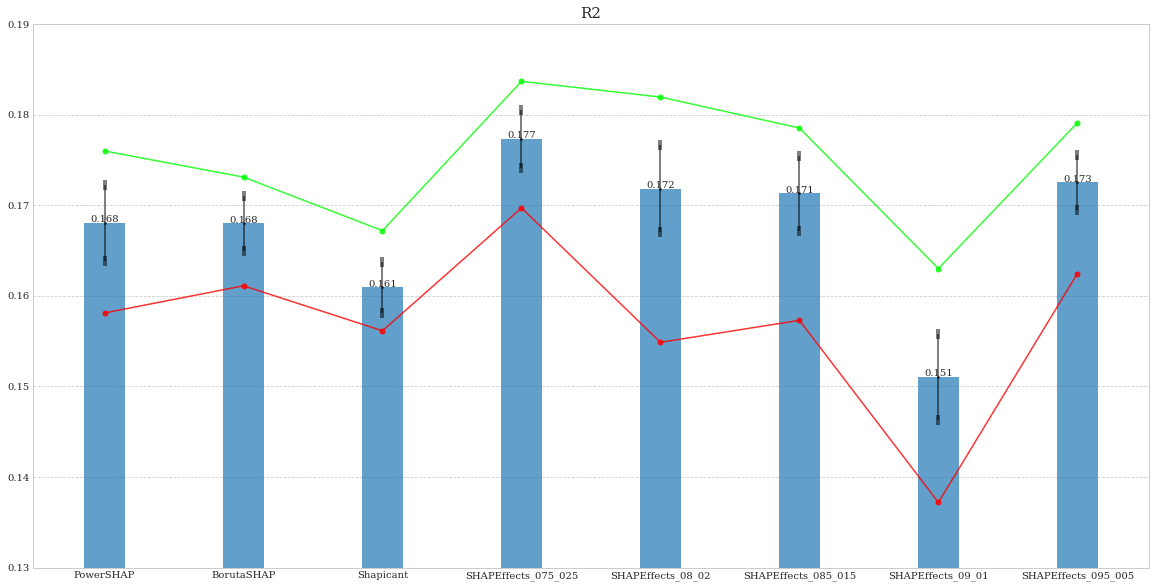

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.0001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0.13, 0.19])

## Number of variables

In [96]:
n_var = [len(selected_features_powershap), len(selected_features_borutashap), len(selected_features_shapicant), len(selected_features_shapeffects_075_025), len(selected_features_shapeffects_08_02), len(selected_features_shapeffects_085_015), len(selected_features_shapeffects_09_01), len(selected_features_shapeffects_095_005)]

(0.0, 85.0)

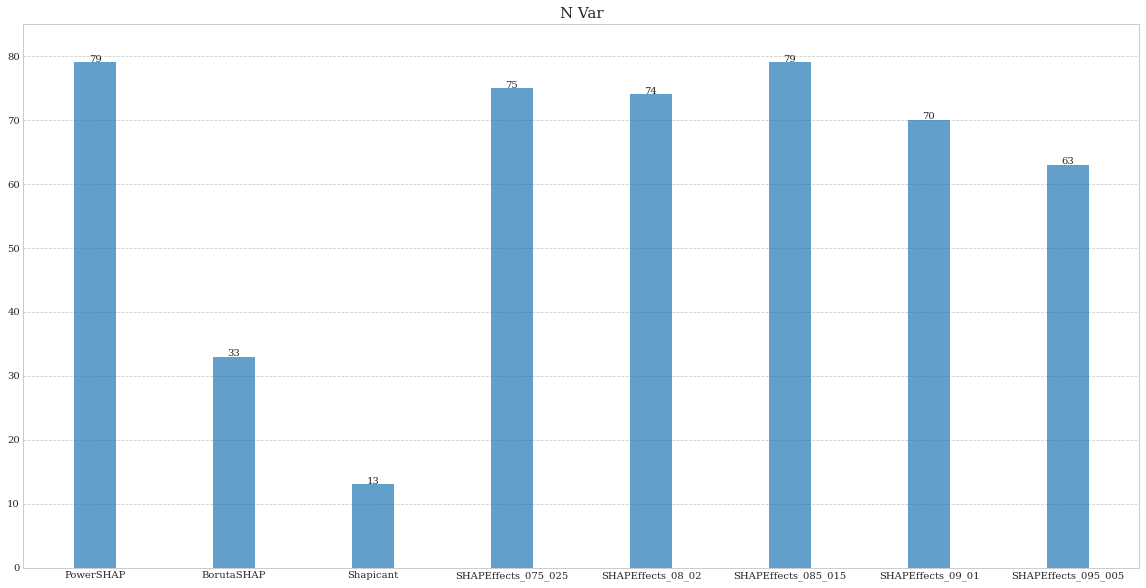

In [97]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.1 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 85])